<font size=7>The pre-processing of eye movement data and the detection of saccades<font>

<font size=3>The eye movement signal from the eyetracker is usually very noisy, especially at high frequencies. In the graph below you can see the speed profile of the start of a smooth pursuit eye movement, which is interrupted by a saccade from approx. 0.2 to approx. 0.25 s. The black horizontal line indicates the target velocity of the eye movement (around 10 deg/s). Obviously, the noise exceeds the actual eye-tracking speed many times over. This is why high frequencies are often filtered out of the signal.<font>

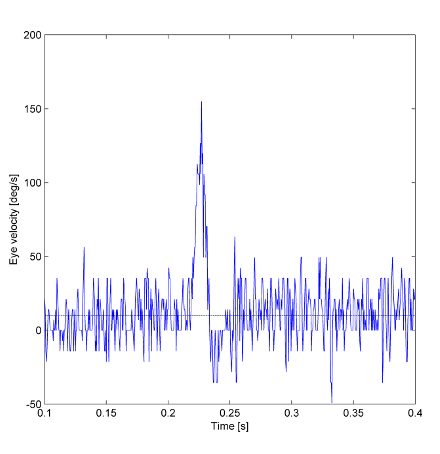

In [1]:
from scipy.signal import filtfilt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
#from ipywidgets import interact
import warnings

warnings.filterwarnings('ignore')

#Constants
COL_T = 0
COL_X = 1
COL_Y = 2
COL_DX = 3
COL_DY = 4
COL_DXF = 5
COL_DYF = 6

#Functions
def detectSaccade(time, x, dx, params=None):#, DEBUG=False):
    if params is None:
        params = [0.05, 0.005, 0.3, 25]

    # Parameters
    sample_freq = 1 / np.mean(np.diff(time))
    ws = round(params[0] * sample_freq)
    ps = [round(params[1] * sample_freq), round(params[1] * sample_freq)]
    # x_crit = params[2]
    dx_crit = params[3]
    # pause_dur = 0.02

    # Detection
    sacc = []
    i = ws + 1
    while i < len(dx) - ps[0]:
        bl = np.mean(dx[i - ws:i - 1])
        crit = np.abs(dx[i:i + ps[0]] - bl)

        #if DEBUG:
            # Plotting for debugging
         #   pass

        if np.any(crit < dx_crit):
            ONSET_SC_X = i
          #  if DEBUG:
           #     pass  # Plotting for debugging

            while i < len(dx) - ps[1]:
                i += 1
                crit = np.abs(dx[i:i + ps[1]] - bl)

            #    if DEBUG:
             #       pass  # Plotting for debugging

                if np.any(crit > dx_crit):
                    sacc.append([ONSET_SC_X, i])
                    i += ws
                    break
        i += 1

    return sacc


def movingAverage(t, x, window_size):
    # Implement moving average calculation
    return filtfilt(np.ones(window_size) / window_size, 1, x, padtype='constant')


def B_filter_trace(filter_length, remove_saccades=False):
    # SHOW_FILTER = True

    # Load data from file
    #data = pd.read_csv(
     #  '/Users/patrikpolgari/Documents/Postdoc_Marburg/student_supervision/Teaching/B-NP2_Übung/Code/Jupyter/data_task_B/eye.dat', header=None, delimiter='\s+')
    data = pd.read_csv('data_task_B/eye.dat', header=None, delimiter='\s+')

    # B2: plot raw velocity
    # Determine sampling frequency
    sample_freq = 1 / np.mean(np.diff(data[COL_T]))

    # Differentiate to obtain eye velocity
    data[COL_DX] = np.append(np.diff(data[COL_X]) * sample_freq, np.nan)
    data[COL_DY] = np.append(np.diff(data[COL_Y]) * sample_freq, np.nan)

    # Plot eye velocity
    # plt.plot(data[COL_T], data[COL_DX], 'b-')
    # plt.ylim(-50, 200)
    # plt.xlim(data[COL_T].iloc[0], data[COL_T].iloc[-1])
    # plt.xlim(0.1, 0.4)
    # plt.xlabel('Time [s]')
    # plt.ylabel('Eye velocity [deg/s]')
    # # plt.axis('square')
    # plt.plot([0, 1], [10, 10], 'k--')
    # plt.plot(data[COL_T], data[COL_DXF], 'r-')

    # Low-pass filtering
    # if SHOW_FILTER:
    data[COL_DXF] = data[COL_DX]
    data[COL_DYF] = data[COL_DY]
    if remove_saccades == True:
        sacc = detectSaccade(data[COL_T], data[COL_X], data[COL_DX], params=None, )

        for sb, se in sacc:
            vb = np.mean(data.iloc[int(round(sb - 0.05 * sample_freq)):sb, COL_DXF])
            ve = np.mean(data.iloc[se:int(round(se + 0.05 * sample_freq)), COL_DXF])
            data.iloc[sb:se, COL_DXF] = np.interp(
                data.iloc[sb:se, COL_T], [data.iloc[sb, COL_T], data.iloc[se, COL_T]], [vb, ve])
            plt.plot(data.iloc[sb:se, COL_T], data.iloc[sb:se, COL_DX],
                     'go', markersize=3, alpha=0.5)
            plt.plot(data.iloc[sb:se, COL_T], data.iloc[sb:se, COL_DXF], 'g-')

        data.iloc[:-1, COL_DXF] = movingAverage(data.iloc[:-1, COL_T], data.iloc[:-1, COL_DXF], int(
            filter_length*sample_freq))  # int(1/filter_length))
        data.iloc[-1, COL_DXF] = np.nan
        data.iloc[:-1, COL_DYF] = movingAverage(data.iloc[:-1, COL_T], data.iloc[:-1, COL_DYF], int(
            filter_length*sample_freq))  # int(1/filter_length))
        data.iloc[-1, COL_DYF] = np.nan
    else:
        data.iloc[:-1, COL_DXF] = movingAverage(data.iloc[:-1, COL_T], data.iloc[:-1, COL_DX], int(
            filter_length*sample_freq))  # int(1/filter_length))
        data.iloc[-1, COL_DXF] = np.nan
        data.iloc[:-1, COL_DYF] = movingAverage(data.iloc[:-1, COL_T], data.iloc[:-1, COL_DY], int(
            filter_length*sample_freq))  # int(1/filter_length))
        data.iloc[-1, COL_DYF] = np.nan
        # data[COL_DXF] = filtfilt(np.ones(filter_length) / filter_length, 1, data[COL_DX], padtype='constant')
        # data[COL_DYF] = filtfilt(np.ones(filter_length) / filter_length, 1, data[COL_DY], padtype='constant')

        # Plot the filtered traces
    plt.plot(data[COL_T], data[COL_DX], 'b-')
    plt.plot(data[COL_T], data[COL_DXF], 'r-')
    if remove_saccades:
        plt.legend(['Original', 'Removed saccade',
                   f'Filtered w/o sacc. {filter_length:.4f} s'], loc='upper left')
        plt.plot(data.iloc[sb:se, COL_T], data.iloc[sb:se, COL_DX],
                 'go', markersize=3, alpha=0.5)
        plt.plot(data.iloc[sb:se, COL_T], data.iloc[sb:se, COL_DXF], 'g-')
    else:
        plt.legend(['Original', f'Filtered {filter_length:.4f} s'], loc='upper left')

    # plt.plot(data[COL_T], data[COL_DX], 'b-')
    plt.ylim(-50, 200)
    plt.xlim(data[COL_T].iloc[0], data[COL_T].iloc[-1])
    plt.xlim(0.1, 0.4)
    plt.xlabel('Time [s]')
    plt.ylabel('Eye velocity [deg/s]')
    # plt.axis('square')
    plt.plot([0, 1], [10, 10], 'k--')
    plt.plot(data[COL_T], data[COL_DXF], 'r-')

    plt.box(False)
    #plt.savefig(f'B_filter_trace_{filter_length}_{remove_saccades}.png', dpi=600)
    plt.show()



def B_detect_saccade(v_crit, v_dur):#, DEBUG=False
    #data = pd.read_csv('/Users/patrikpolgari/Documents/Postdoc_Marburg/student_supervision/Teaching/B-NP2_Übung/Code/Jupyter/data_task_B/eye.dat', header=None, delimiter='\s+')
    data = pd.read_csv('data_task_B/eye.dat', header=None, delimiter='\s+')
    sample_freq = 1 / np.mean(np.diff(data.iloc[:, COL_T]))

    # Differentiate to obtain eye velocity
    data.iloc[:-1, COL_DX] = np.diff(data.iloc[:, COL_X]) * sample_freq
    data.iloc[-1, COL_DX] = np.nan
    data.iloc[:-1, COL_DY] = np.diff(data.iloc[:, COL_Y]) * sample_freq
    data.iloc[-1, COL_DY] = np.nan

    sacc1 = []
    # sacc2 = []
    params1 = [0.01, v_dur, 0.3, v_crit]

    if v_crit is not None:
        sacc1 = detectSaccade(data.iloc[:, COL_T], data.iloc[:, COL_X], data.iloc[:, COL_DX], params1)#, DEBUG)

    plt.figure(figsize=(10, 8))

    for t in range(2):
        plt.subplot(2, 2, t + 1)
        plt.plot(data.iloc[:, COL_T], data.iloc[:, COL_X], 'k-')
        for sb, se in sacc1:
            plt.plot(data.iloc[sb, COL_T], data.iloc[sb, COL_X], 'rx')
            plt.plot(data.iloc[se, COL_T], data.iloc[se, COL_X], 'bx')
        plt.xlim(data.iloc[0, COL_T], data.iloc[-1, COL_T])
        plt.xlabel('Time [s]')
        plt.ylabel('Eye position [deg]')
        # plt.axis('square')
        if t == 0:
            plt.text(-0.1, 10, f'v-crit: {v_crit:.4f}\nv-dur: {v_dur:.4f}')
        if t == 1:
            plt.xlim(0.2, 0.25)
        plt.box(False)

    for t in range(2):
        plt.subplot(2, 2, t + 3)
        plt.plot(data.iloc[:, COL_T], data.iloc[:, COL_DX], 'k-')
        for sb, se in sacc1:
            plt.plot(data.iloc[sb, COL_T], data.iloc[sb, COL_DX], 'rx')
            plt.plot(data.iloc[se, COL_T], data.iloc[se, COL_DX], 'bx')
        plt.ylim(-400, 400)
        plt.xlim(data.iloc[0, COL_T], data.iloc[-1, COL_T])
        plt.xlabel('Time [s]')
        plt.ylabel('Eye velocity [deg/s]')
        # plt.axis('square')
        if t == 1:
            plt.xlim(0.2, 0.25)
        plt.box(False)

    plt.tight_layout()
    #plt.savefig(f'B_detect_saccade_{v_crit}_{v_dur}.png', dpi=600)
    plt.show()

/var/folders/8l/8mhtfcfd3kx35x8ns523w5zm0000gn/T/ipykernel_69321/474644140.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


<font size=5>1. Data filtering<font> 

<font size=3>Use the **filter_length** slider to see the result of varying degrees of filtering, e.g: **filter_length = 0.05**

<font size=3>The **filter_length** parameter defines the time period (in seconds) over which neighboring values are averaged. Useful values are 0.001 to 0.1. Vary the parameter and describe the effects using the graphics. Do you recognize a problem with higher values?

<font size=3>You can exclude the saccade before filtering by selecting the **remove_saccades** checkbox.

<font size=3>How does the filtered signal change? Which filter value would you prefer?<font>

In [2]:
widgets.interact(B_filter_trace, 
         filter_length=widgets.FloatSlider(min=0.001, max=0.1, step=0.001, value=0.001, readout_format='.3f'),
         remove_saccades=False)
#interact(B_filter_trace, filter_length=(0.001, 0.1, 0.001))
#B_filter_trace(0.01, remove_saccades=True)

interactive(children=(FloatSlider(value=0.001, description='filter_length', max=0.1, min=0.001, readout_format…

<function __main__.B_filter_trace(filter_length, remove_saccades=False)>

<font size=5>2. Saccade detection<font> 

<font size=3>To detect saccades, a critical velocity value is usually defined from which a saccade is detected (**v_crit** in deg/s, 1 to 200). To ensure that the result is not too easily influenced by individual outliers due to noise, the time period over which the critical value must be exceeded is usually also specified (**v_dur** in seconds, 0.001 to 0.02). 

<font size=3>Use the sliders below (**v_crit, v_dur**) to test the detection algorithm with different settings of **v_crit** and **v_dur**, e.g: v_crit = 10 deg/s; v_dur = 0.001 s.

<font size=3>The start of a saccade is marked with a red cross and the end with a blue cross. 


<font size=3>Compare different values for **v_crit** and **v_dur** and determine the optimum settings.


In [3]:
#interact(B_detect_saccade, v_crit=(1,200,1), v_dur=(0.001, 0.02, 0.001), DEBUG=False)
widgets.interact(B_detect_saccade, 
         v_crit=widgets.IntSlider(min=1, max=200, step=1, value=1), 
         v_dur=widgets.FloatSlider(min=0.001, max=0.02, step=0.001, value=0.001, readout_format='.3f'))


interactive(children=(IntSlider(value=1, description='v_crit', max=200, min=1), FloatSlider(value=0.001, descr…

<function __main__.B_detect_saccade(v_crit, v_dur)>